---
title: Map Vectors!
subtitle: DSE EcoTech Series (2024)
author:
    name: Brookie Guzder-Williams
    affiliations: 
        - The Eric and Wendy Schmidt Center for Data Science & Environment
        - University of California Berkeley
    orcid: 0000-0001-6855-8260
    email: bguzder-williams@berkeley.edu
date: 2024-10-23
---

license: CC-BY-4.0


---

### IMPORTS

In [1]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import leafmap
import lonboard
import matplotlib.pyplot as plt
import seaborn as sns
from sidecar import Sidecar
import rich.pretty as rp


---

### CONSTANTS

In [2]:
FIRES = '../data/vector/CalFires_Boundaries21'
ZOOM = 6
MAP_HEIGHT = 1000
X = -120.0
Y = 37.0
MAP_CENTER = (Y, X)

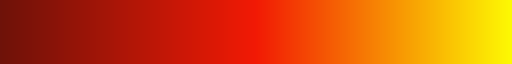

In [3]:
COLOR_LIST = [
    "#FF0000",  # Red
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#FF00FF",  # Magenta
    "#00FFFF",  # Cyan
    "#FFFFFF",  # White
    "#000000",  # Black
    "#FFC0CB",  # Pink
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#808000",  # Olive
    "#008000",  # Dark Green
    "#008080",  # Teal
    "#A52A2A",  # Brown
    "#C0C0C0",  # Silver
    "#800000",  # Maroon
    "#87CEEB",  # Sky Blue
    "#FFD700",  # Gold
]
CONTINUOUS_PALETTE = sns.color_palette("blend:#6e1209,#f21a05,#fdf903", as_cmap=True)
display(CONTINUOUS_PALETTE)


---

### HELPERS

In [4]:
def minmax_norm(values, clip=[0,50000]):
    if clip:
        values = values.clip(*clip) 
    return (values - values.min()) / (values.max() - values.min())

def directory_size(directory):
    total_size = 0
    for file in Path(directory).rglob("*"):
        if file.is_file():
            total_size += file.stat().st_size
    return total_size

def line():
    print('-' * 75)


---

### GEOPANDAS

data shape: (16327, 22)
example:


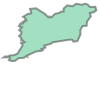

{
│   'YEAR_': '2021',
│   'STATE': 'CA',
│   'AGENCY': 'CDF',
│   'UNIT_ID': 'TCU',
│   'FIRE_NAME': 'WASHINGTON',
│   'INC_NUM': '00011085',
│   'ALARM_DATE': '2021-08-26T00:00:00+00:00',
│   'CONT_DATE': '2021-08-31T00:00:00+00:00',
│   'CAUSE': 14.0,
│   'COMMENTS': 'Fire was on SRA and LRA, Cause Undtermined',
│   'REPORT_AC': 136.5,
│   'GIS_ACRES': 135.77529907226562,
│   'C_METHOD': 1.0,
│   'OBJECTIVE': 1.0,
│   'FIRE_NUM': None,
│   'Shape_Leng': 4465.935130203889,
│   'Shape_Area': 549463.1248829946,
│   'COMPLEX_NA': None,
│   'COMPLEX_IN': None,
│   'millis': 1629936000000,
│   'date': '2021-08-26',
│   'geometry': <POLYGON ((-120.401 37.963, -120.401 37.963, -120.401 37.963, -120.402 37.96...>
}

In [5]:
#| label: nb:vector:gpd
gdf = gpd.read_file(FIRES)
gdf = gdf.to_crs(epsg=4326)
print('data shape:', gdf.shape)
print('example:')
row = gdf[(gdf.GIS_ACRES > 100) & (gdf.YEAR_=='2021')].sample().iloc[0]
display(row.geometry)
rp.pprint(row.to_dict())

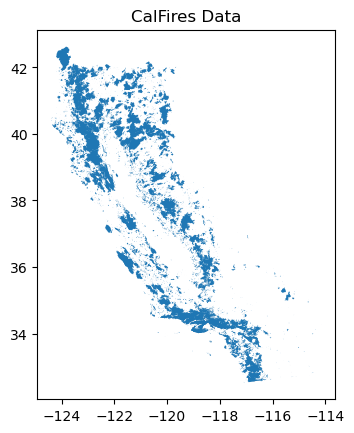

In [6]:
#| label: nb:vector:gpdplot
ax = gdf.plot()
txt = ax.set_title('CalFires Data')


---

### FILE TYPES

In [7]:
#| label: nb:vector:filetypes
line()
print('parq, json, gpkg, (shp)')
line()
print('SAVE')
%time gdf.to_parquet('fires.parquet')
%time gdf.to_file('fires.json', driver="GPKG")
%time gdf.to_file("fires.gpkg", layer='calfires', driver="GPKG")
line()
print('READ')
%time gdf_parq = gpd.read_parquet('fires.parquet')
%time gdf_json = gpd.read_file('fires.json', driver="GPKG")
%time gdf_gpkg = gpd.read_file("fires.gpkg", layer='calfires', driver="GPKG")
line()
print('SIZE')
print('parq:', Path('fires.parquet').stat().st_size)
print('json:', Path('fires.json').stat().st_size)
print('gpkg:', Path('fires.gpkg').stat().st_size)
print('shp: ', directory_size(FIRES))

---------------------------------------------------------------------------
parq, json, gpkg, (shp)
---------------------------------------------------------------------------
SAVE
CPU times: user 219 ms, sys: 54 ms, total: 273 ms
Wall time: 285 ms
CPU times: user 345 ms, sys: 349 ms, total: 693 ms
Wall time: 818 ms
CPU times: user 351 ms, sys: 350 ms, total: 700 ms
Wall time: 835 ms
---------------------------------------------------------------------------
READ
CPU times: user 175 ms, sys: 73.6 ms, total: 249 ms
Wall time: 242 ms
CPU times: user 202 ms, sys: 46.5 ms, total: 248 ms
Wall time: 249 ms
CPU times: user 202 ms, sys: 42 ms, total: 244 ms
Wall time: 245 ms
---------------------------------------------------------------------------
SIZE
parq: 95010603
json: 108892160
gpkg: 108892160
shp:  117379885



---

##### SOME PREPROCESSING

In [8]:
cause_na = gdf.CAUSE.isna()
gdf.loc[cause_na,'CAUSE'] = -1
gdf.loc[~cause_na,'CAUSE'] = gdf.loc[~cause_na].CAUSE.astype(int)
gdf['year'] = gdf.YEAR_.astype(int)
CAUSES = gdf.CAUSE.sort_values().unique()
gdf.year.min(), gdf.year.max()

(np.int64(1898), np.int64(2021))



---

### LEAFMAP

If I try and add all 16k polygons it crashes so I'll filter to years > 2015... but it's still slow

In [9]:
_gdf = gdf[gdf.year>2015]
print('dataset sizes:', gdf.shape[0], _gdf.shape[0], _gdf.shape[0]/gdf.shape[0])

dataset sizes: 16327 2553 0.1563667544558094


In [10]:
#| label: nb:vector:leafmap
_gdf = gdf[gdf.year>2015]
leafmap_map = leafmap.Map(zoom=ZOOM)
leafmap_map.center = MAP_CENTER
leafmap_map.add_gdf(_gdf, layer_name='Fires', fill_colors=["red", "yellow", "green", "orange"])
leafmap_map

Map(center=[37.0, -120.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…


---

### LONBOARD




---


In [11]:
lonboard_map = lonboard.Map(
    [], 
    view_state=dict(
        longitude=X,
        latitude=Y,
        zoom=ZOOM),
    use_device_pixels=False)
lonboard_map._height =  MAP_HEIGHT

layer = lonboard.PolygonLayer.from_geopandas(
    gdf,
    get_line_width=20,
    line_width_min_pixels=0.2,
    get_fill_color='#039d89',
    get_line_color='#103c28',
)

lonboard_map.add_layer(layer)
sc = Sidecar(title='Lonboard Fires')
with sc:
    display(lonboard_map)

In [12]:
layer.get_fill_color = lonboard.colormap.apply_categorical_cmap(
    gdf.CAUSE,
    {c: clr for c, clr in zip(CAUSES, COLOR_LIST)})

In [13]:
severity_values = minmax_norm(gdf.GIS_ACRES.values)
layer.get_fill_color = lonboard.colormap.apply_continuous_cmap(
    severity_values,
    CONTINUOUS_PALETTE)